In [88]:
# Wbudowany VGG16 z drobnymi modyfikacjami
# https://towardsdatascience.com/anomaly-detection-in-images-777534980aeb

# ogólne
import tensorflow as tf
import numpy as np

# ładowanie danych
from keras.preprocessing.image import ImageDataGenerator

# budowanie modelu
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import SGD
from keras.applications import VGG16
from keras import Model

# proces uczenia
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

# wizualizacja
import matplotlib.pyplot as plt
from keras.utils import load_img
import pickle

# klasyfikacja
from keras.models import load_model

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)  
# tf.data.experimental.enable_debug_mode()

In [89]:
# Przygotowanie danych
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

path = r"C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1\train"

datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255)

train_data = datagen.flow_from_directory(directory=path,
                                         target_size=(224,224),
                                         shuffle=True,
                                         subset='training') # set as training data

valid_data = datagen.flow_from_directory(directory=path,
                                         target_size=(224,224),
                                         shuffle=True,
                                         subset='validation') # set as validation data

# test_data = ImageDataGenerator(rescale=1./255)\
#     .flow_from_directory(directory="test",
#                          target_size=(224,224))

Found 1082 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [90]:
unique_train = np.unique(train_data.classes, return_counts=True)
labels_dict_train = dict(zip(unique_train[0], unique_train[1]))
print(labels_dict_train)

unique_valid = np.unique(valid_data.classes, return_counts=True)
labels_dict_valid = dict(zip(unique_valid[0], unique_valid[1]))
print(labels_dict_valid)

{0: 192, 1: 890}
{0: 33, 1: 157}


In [91]:
def get_class_weight(data):
    n_samples = len(data)
    n_classes = len(np.unique(data))

    class_weight = dict()

    for classes in np.unique(data):
        score = n_samples/(n_classes*np.bincount(data)[classes])
        class_weight[classes] = score
        
    return class_weight

In [92]:
class_weights = get_class_weight(train_data.classes)
class_weights

{0: 2.8177083333333335, 1: 0.6078651685393258}

In [93]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

In [94]:
x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)
model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [95]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [96]:
steps = 10
epoch = 10

# String formatting rules - https://mkaz.blog/code/python-string-format-cookbook/
filepath="models/weights-improvement-{epoch:03d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=20,
                      verbose=1,
                      mode='auto')

hist = model.fit_generator(steps_per_epoch=steps,
                           generator=train_data,
                           validation_data=valid_data,
                           validation_steps=1,
                           epochs=epoch,
                           callbacks=[checkpoint,early],
                           class_weight=class_weights)

C:\Users\User\AppData\Local\Temp\ipykernel_10336\757047182.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=steps,


Epoch 1/10
 8/10 [=======================>......] - ETA: 42s - loss: 0.7464 - accuracy: 0.2109 

KeyboardInterrupt: 

In [24]:
# zapisanie historii nauki
name = "epochs_{}_steps_{}_{:%Y_%m_%d_%H_%M}".format(checkpoint.params['epochs'], checkpoint.params['steps'], datetime.now())
with open('trainHistoryDict/{}.pickle'.format(name), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# otwarcie historii nauki
with open('trainHistoryDict/{}.pickle'.format(name), "rb") as file_pi:
    history = pickle.load(file_pi)

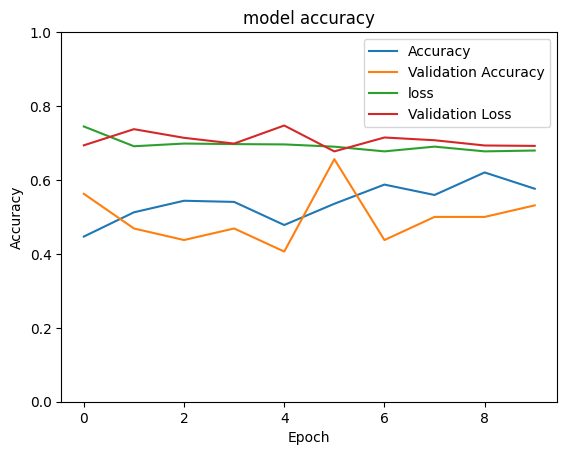

In [25]:
plt.plot(history["accuracy"])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0, 1) 
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [28]:
os.getcwd()

'c:\\Users\\User\\Desktop\\Matematyka stosowana - II stopień\\III semestr\\Uczenie ze wzmocnieniem i deeplearning\\deep_learning\\Zadanie 1\\VGG-16'

[9.9987769e-01 1.2234796e-04]
fake face


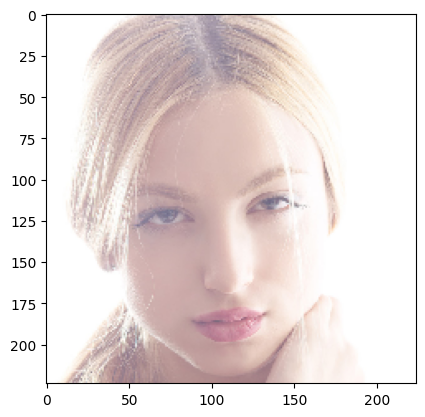

In [87]:
loc = r"C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1\test\TS1"

img = load_img(loc+"\\test_image_set1 (7).jpg", target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

saved_model = load_model("models/weights-improvement-006-0.66.hdf5")
output = saved_model.predict(img, verbose=0)
print(output[0])

if output[0][0] > output[0][1]:
    print("fake face")
else:
    print('real face')